In [328]:
%matplotlib inline
import torch
import random
import matplotlib.pyplot as plt

### synthesis data

Presume ***y =  3x - 2y + 1***

Hence the *W* matricx may like $\mathbf{w} = [3, -2]^\top$, $\mathbf{b} = [1]$

In [329]:
def synthesis_data(w, b, n):
    x = torch.normal(0, 1, (n, w.shape[0]))
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return x, y.reshape(-1, 1)

w_true = torch.tensor([3., -2.]) # must be float, otherwise the torch.matmul will fail
b_true = torch.tensor([1])

features, labels = synthesis_data(w_true, b_true, 1000)

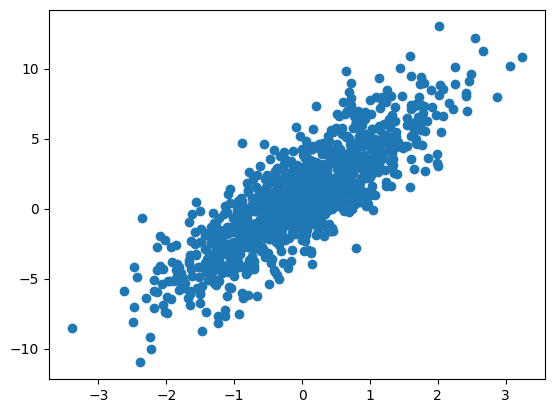

In [330]:
# features[:,:1] means slecct a sub matrix with all rows and the column through [0, 1),
# so it's just only column 0.
plt.scatter(features[:,:1], labels)

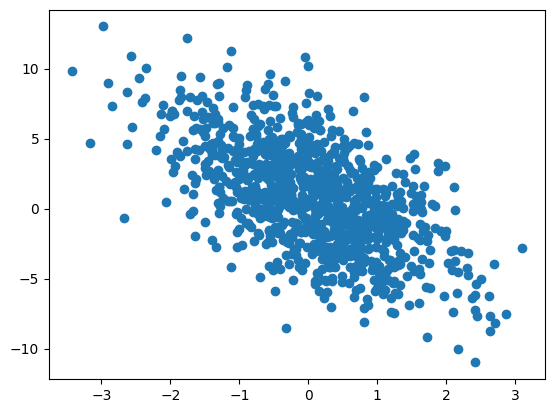

In [331]:
# features[:,1:] means slecct a sub matrix with all rows and the column through [1, -1),
# so it's just only column 1 in such case,
# because there is just two columns (0 and 1).
plt.scatter(features[:,1:], labels)

In [332]:
def batch_iterator(batch_size, features, labels):
    cnt = len(features)
    indices = list(range(0, cnt))
    random.shuffle(indices)
    for i in range(0, cnt, batch_size):
        batch_indices = indices[i: min(i + batch_size, cnt)]
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for x, y in batch_iterator(batch_size, features, labels):
    print(x, '\n', y)
    break

tensor([[ 8.7360e-01, -4.1121e-01],
        [ 7.0502e-01,  7.9694e-01],
        [-1.0472e-01, -1.7636e-03],
        [ 8.1891e-01, -1.7553e+00],
        [-3.7428e-01,  7.7617e-01],
        [-2.0150e+00,  1.1951e+00],
        [-3.8965e-01, -7.6011e-01],
        [-2.2579e-01,  3.3853e-01],
        [-3.1274e-01,  1.5287e+00],
        [-1.9946e+00,  6.6363e-01]]) 
 tensor([[ 4.4397],
        [ 1.5180],
        [ 0.6677],
        [ 6.9563],
        [-1.6611],
        [-7.4182],
        [ 1.3564],
        [-0.3427],
        [-2.9994],
        [-6.3057]])


In [333]:
# We didn't utilize "requires_grad=True" as an argument here, because we would like to
# implement the gradient by ourselves.
w = torch.normal(0, 0.01, size=(2,1))
b = torch.zeros(1)
#b = torch.tensor([1.])

In [334]:
def linear_regression(x, w, b):
    return torch.matmul(x, w) + b

In [335]:
def square_loss(y, y_true):
    cur_loss = (y - y_true) ** 2
    return cur_loss

In [336]:
stride = 0.01
lr = 0.03
def backward(x, y, w, b, loss_mean):
    # derivative for w
    w_diff = torch.tensor([0., 0.]).reshape(-1, 1)
    for i in range(len(w)):
        wi_new = w.detach().clone()
        wi_new[i] += stride
        loss_wi = square_loss(linear_regression(x, wi_new, b), y)
        loss_mean_wi = loss_wi.sum() / len(x)
        dwi = (loss_mean_wi - loss_mean) / stride
        w_diff[i] = (dwi * lr).reshape(w_diff[i].shape)
    b_new = b + stride
    loss_b = square_loss(linear_regression(x, w, b_new), y)
    loss_mean_b = loss_b.sum() / len(x)
    db = (loss_mean_b - loss_mean) / stride
    '''
    ------------------------------------------------------------
    Must do stochastic gradient decremnt after we have already
    calculated all the gradient, if we mins one gradient of a
    parameter before we calculated another parameter, it will
    bring accumulated influence to another parameter, so the 
    algroithm will not convergence
    ------------------------------------------------------------
    '''
    b -= db * lr
    w -= w_diff
    return w, b

In [337]:
epochs = 3
for epoch in range(0, epochs):
    for x, y in batch_iterator(10, features, labels):
        loss = square_loss(linear_regression(x, w, b), y)
        loss_mean = loss.sum() / len(x)
        w, b = backward(x, y, w, b, loss_mean)
    ls = square_loss(linear_regression(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(ls.mean()):f}')
    #print("w is: ", w)
    #print("b is: ", b)

epoch 1, loss 0.000349
epoch 2, loss 0.000173
epoch 3, loss 0.000181
